In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.4)
import copy

In [2]:
df = pd.read_csv("data/flights_cleaned_no_outlier_iqr_with_delays.csv")

In [3]:
df.shape

(2073115, 39)

In [4]:
df.keys()

Index(['Unnamed: 0', 'fl_date', 'mkt_unique_carrier', 'branded_code_share',
       'mkt_carrier', 'mkt_carrier_fl_num', 'op_unique_carrier',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'weather_type', 'passengers', 'month',
       'combined_delay'],
      dtype='object')

In [5]:
very_important_columns = [ # ran with what the test data can do
    'op_unique_carrier', # most extensive name list
    'origin_airport_id', # need 'origin' to merge weather but already merged! ;)
    'dest_airport_id',
    'crs_dep_time',
    'dep_time', # only using in TRAIN, to learn how other columns affect this
    'crs_arr_time',
    'arr_time', # only using in TRAIN, to learn how other columns affect this
    'weather_type', # cannot use delay columns
    'passengers',
    'arr_delay' # so we can make a target column...
]

In [6]:
df_ = df.filter(items=very_important_columns)

In [7]:
df_dummies = pd.get_dummies(df_, columns=['weather_type'])

In [8]:
df_dummies = pd.get_dummies(df_dummies, columns=['op_unique_carrier'])

In [9]:
df_dummies

origin_airport_id  dest_airport_id  crs_dep_time  dep_time  \
0                    10581            11278           543     535.0   
1                    10581            13930          1328    1324.0   
2                    10581            12953          1449    1449.0   
3                    10581            14761          1301    1308.0   
4                    10581            14100          1001     951.0   
...                    ...              ...           ...       ...   
2073110              11905            11298          1835    1828.0   
2073111              11905            11298          1039    1029.0   
2073112              15401            11298          1353    1344.0   
2073113              15401            11298          1955    1941.0   
2073114              15401            11298           628     622.0   

         crs_arr_time  arr_time  passengers  arr_delay  weather_type_Cloudy  \
0                 749     731.0     85523.0      -18.0                    0   
1                1530    1529.0     85523.0       -1.0                    0   
2                1629    1614.0     85523.0      -15.0                    0   
3                1623    1559.0     85523.0      -24.0                    0   
4                1149    1134.0     85523.0      -15.0                    0   
...               ...       ...         ...        ...                  ...   
2073110          1945    1935.0     10465.0      -10.0                    0   
2073111          1149    1119.0     10465.0      -30.0                    0   
2073112          1506    1455.0     14422.0      -11.0                    0   
2073113          2109    2050.0     14422.0      -19.0                    0   
2073114           745     712.0     14422.0      -33.0                    0   

         weather_type_Rainy  weather_type_Snowy  weather_type_Sunny  \
0                         1                   0                   0   
1                         1                   0                   0   
2                         1                   0                   0   
3                         1                   0                   0   
4                         1                   0                   0   
...                     ...                 ...                 ...   
2073110                   0                   0                   1   
2073111                   0                   0                   1   
2073112                   1                   0                   0   
2073113                   1                   0                   0   
2073114                   1                   0                   0   

         op_unique_carrier_9E  op_unique_carrier_AA  op_unique_carrier_AS  \
0                           0                     0                     0   
1                           0                     0                     0   
2                           0                     0                     0   
3                           0                     0                     0   
4                           0                     0                     0   
...                       ...                   ...                   ...   
2073110                     0                     0                     0   
2073111                     0                     0                     0   
2073112                     0                     0                     0   
2073113                     0                     0                     0   
2073114                     0                     0                     0   

         op_unique_carrier_AX  op_unique_carrier_B6  op_unique_carrier_C5  \
0                           0                     0                     0   
1                           0                     0                     0   
2                           0                     0                     0   
3                           0                     0                     0   
4                           0               

## Main Task: Regression Problem
The target variable is ARR_DELAY. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.
For example, variables CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.
We will be evaluating your models by predicting the ARR_DELAY for all flights 1 week in advance.

In [54]:
df_checkpoint = df_dummies.copy()

In [55]:
df_checkpoint = df_checkpoint.sample(frac=0.10) # around 200k columns?

In [56]:
# scale/normalize

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

#scaling

scaler = StandardScaler()
scaler.fit(X)

X = scaler.transform(df_checkpoint.loc[:, df_checkpoint.columns != 'arr_delay'])

In [58]:
X = pd.DataFrame(X)

In [59]:
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()

In [60]:
np.all(np.isfinite(X))

True

In [61]:
np.any(np.isnan(X))

False

In [62]:
# finally make X and y
X = df_checkpoint.drop(columns = ['arr_delay'])
y = df_checkpoint['arr_delay']

In [64]:
X.shape

(207312, 37)

In [66]:
y = pd.DataFrame(y)

In [68]:
y.shape

(207312, 1)

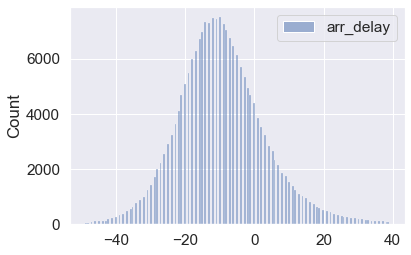

In [69]:
sns.histplot(y);

In [70]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.80,random_state=42)

In [71]:
from sklearn.linear_model import Lasso, Ridge, SGDRegressor, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from numpy import absolute
from numpy import mean
from numpy import std

## training time.

In [245]:
# # 0.060 score
# model = Lasso(alpha=1.0)
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# # force scores to be positive
# scores = absolute(scores)
# print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 9.662 (0.060)


In [75]:
# # 0.036 score
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import make_classification
# clf = RandomForestClassifier(max_depth=2, random_state=42)
# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)

# # 0.03 score
# from sklearn.metrics import accuracy_score
# accuracy = accuracy_score(y_test,y_pred)
# print(accuracy)

0.036659190121312975


In [ ]:
# parameter grid
parameter_candidates = {
    'n_estimators':[100, 200, 300],
    'max_depth':[1, 2, 3, 4, 5]
}
from sklearn import datasets, svm
from sklearn.model_selection import GridSearchCV
grid_result = GridSearchCV(clf, param_grid=parameter_candidates)
the_fit = grid_result.fit(X_train, y_train.values.ravel())
bestresult = grid_result.best_estimator_

In [ ]:
# View the accuracy score first run: MD3, nest100
print('Best score for data1:', grid_result.best_score_) 
print(grid_result.best_params_)
print(bestresult)
grid_result.score(X_train, y_train)